# OpenFOAM raeding for Pyvista
source: https://docs.pyvista.org/examples/99-advanced/openfoam-example

In [1]:
from __future__ import annotations
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import pandas as pd
import sys
import os
import csv


import input_data
import particle_init
import OpenFOAM_PyVista

# Running tech. details
if not input_data.dynamic_renderer: pv.global_theme.jupyter_backend = 'static'
np.set_printoptions(precision=input_data.numPy_percission)

# Preparatino and opening of an the OpenFOAM case
You must have the case file existing with the .foam extension.
Terminal syntax:

    paraFoam -touch -builtin

Get `grad(U)` and the deformation matrisx, $D$, `symm(grad(U))` from the terminal in the foam case directory:

    postProcess -func "grad(U)" -latestTime

Next, this code will automatically calculates in a method within `Ellipsoid` class.
$$D = \frac{1}{2} \left( \nabla  U + (\nabla U)^T \right)$$
$$ \dot{\gamma} = \sqrt{ 2 \sum_{i<j} D_{ij}^2 }$$ 
$$ \dot{ \varepsilon} = \sqrt{ D_{xx}^2 + D_{yy}^2 + D_{zz}^2} $$

## Conversion of the reader to Pyvista mesh
This is the wrong way because "the default in OpenFOAMReader is to translate the existing cell data to point data. Therefore, the cell data arrays are duplicated in point data.

For the correct way use this syntax:

    print(f"Available Time Values: {reader.time_values}")
    reader.set_active_time_value(2.5)
    reader.cell_to_point_creation = True  # Need point data for streamlines
    mesh = reader.read()
    internal_mesh = mesh["internalMesh"]
    boundaries = mesh["boundary"]

The default in OpenFOAMReader is to translate the existing cell data to point data. Therefore, the cell data arrays are duplicated in point data.

from
https://docs.pyvista.org/api/readers/_autosummary/pyvista.openfoamreader

The stress tensor, $\tau$ is a symmetrical one. So, you'll see 6 numbers instead of 9. Those are tau_XX, tau_YY, tau_ZZ, tau_XY, tau_XZ, and tau_YZ, as the convesion is: $$[τ_{xx}​,τ_{yy}​,τ_{zz​},τ_{xy}​,τ_{xz}​,τ_{yz}​]$$
We sort it out now, Noting that the elongational stress in our case is: $$N_{11} = \tau_{xx}- \tau_{rr} = \tau_{xx}- \sqrt{ \tau_{yy}^2 - \tau_{zz}^2 } $$

In [2]:
#Reading with a given CFD file:
internal_mesh, boundaries = OpenFOAM_PyVista.read_and_prepare_OpenFOAM(print_output=True)

MultiBlock (0x7fa4c80cf880)
  N Blocks    7
  X Bounds    -35.000, 25.000
  Y Bounds    0.000, 4.000
  Z Bounds    0.000, 1.000
Availbale fields at the active time step:  ['p', 'U', 'alpha.water', 'eigVals.water', 'eigVecs.water', 'grad(U)', 'p_rgh', 'tau.water', 'tauMF', 'theta.water', 'U', 'alpha.water', 'eigVals.water', 'eigVecs.water', 'grad(U)', 'p', 'p_rgh', 'tau.water', 'tauMF', 'theta.water', 'U_magnitude', 'N_11', 'shear']
All patch names: ['internalMesh', 'group/empty', 'group/symmetryPlane', 'group/wall', 'patch/inlet', 'patch/wallIn', 'patch/wallOut', 'patch/atmosphere', 'patch/outlet', 'patch/symmetry', 'patch/defaultFaces']
All patch status: {'internalMesh': True, 'group/empty': True, 'group/symmetryPlane': True, 'group/wall': True, 'patch/inlet': True, 'patch/wallIn': True, 'patch/wallOut': True, 'patch/atmosphere': True, 'patch/outlet': True, 'patch/symmetry': True, 'patch/defaultFaces': True}
Boundaries patches: ['inlet', 'wallIn', 'wallOut', 'atmosphere', 'outlet', 's

2024-12-08 16:56:47.679 (   0.289s) [    7FA4CD632B80]  vtkOpenFOAMReader.cxx:9270  WARN| vtkOpenFOAMReaderPrivate (0x2533b940): boundaryField defaultFaces not found in object alpha.water.org at time = 0


### Checking $\nabla U$ before proceeding

In [3]:
if not os.path.isfile(str(input_data.active_time_step) + '/grad(U)'):
    sys.exit("File 'grad(U)' not found. Run the code below on the terminal:\n\n\tpostProcess -func \"grad(U)\" -latestTime \n \nTerminating program.")
else:
    print(f"File grad(U) exists in the folder '{input_data.active_time_step}'. Continuing with the program.")

File grad(U) exists in the folder '120'. Continuing with the program.


### Instruction to save or load a ```mesh```
I must save the Elliposids separately and load them on paraview with the actual mesh.

In [4]:
working_mesh = internal_mesh
working_mesh

UnstructuredGrid (0x7fa4839f07c0)
  N Cells:    12230
  N Points:   25226
  X Bounds:   -3.500e+01, 2.500e+01
  Y Bounds:   0.000e+00, 4.000e+00
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   23

# Plotting all the initial batch of particles within the flow

In [5]:
# Normal vector to the required boundary. Normals Access: The normal vectors are stored in the cell data of the boundary mesh:
release_patch   = boundaries[input_data.particles_initation_patch]
patch_normal    = release_patch.compute_normals(cell_normals=True, point_normals=False)
Normal          = patch_normal['Normals'] 
scale           = input_data.X_max- input_data.X_min

if input_data.screenshot_initiation:
    # plotitng the overall case
    demo_plotter= pv.Plotter()
    list_of_test_particles = []
    particle_init.release_new_particles(list_of_test_particles)
    OpenFOAM_PyVista.plot_all_Ellipoids_in_OF(working_mesh, list_of_test_particles, plotter=demo_plotter, OF_opacity=0.2, background_OF=input_data.include_OF_background)

    # Marking the releasing patch
    demo_plotter.add_title(title= str(input_data.n_points) + " particles are released")# \non + input_data.particles_initation_patch+ " patch directed with red.")
    demo_plotter.add_arrows( patch_normal.center + Normal* scale , -Normal, scale, color='red' )

    #       camera position:
    camera_shift    =   np.linalg.norm( np.array(release_patch.center)  -  np.array(working_mesh.center) ) / 3
    demo_plotter.view_xy()

    demo_plotter.enable_parallel_projection()
    #demo_plotter.show_grid()
    demo_plotter.add_axes()
    demo_plotter.screenshot("initial position.png")

    time.sleep(2)

In [6]:
# Demoing the initial condition
if input_data.screenshot_initiation:
    demo_plotter.add_mesh(working_mesh, opacity=0.1, scalars=working_mesh['U'])
    demo_plotter.show()

Widget(value='<iframe src="http://localhost:45191/index.html?ui=P_0x7fa483a1ce50_0&reconnect=auto" class="pyvi…

# The simulation loop
In this section, the parttciles are released and move with the OpenFOAM flow.
Time is read from the system and $\delta t$ from the `input_data.py`    

Initiating the thread call function

In [7]:
#Staring a report for time, No. breakups, and No. coalescences:
report_table = []; col1_breakups = 0; col2_coalescences = 3

# Function to update a single particle
def update_particle(i, list_of_particles, t, working_mesh, input_data):
    results = {}
    
    # Updating each Ellipsoid:
    list_of_particles[i].update(t, working_mesh)
    
    # Breakups:
    new_particle = list_of_particles[i].check_breakup()
    if new_particle:
        results["new_particle"] = (i, new_particle)
    
    # Droplet removal
    if input_data.remove_droplets_with_warning:
        OpenFOAM_PyVista.delete_ellipsoids_with_warning(list_of_particles)
    
    return results

# Main simulation loop - Reading the initiation data
t_start = time.time(); delta_t = input_data.delta_t; list_of_particles = []; loop_counter = 0; t = 0; newly_born_particles = {}; report_locations = input_data.report_locations.copy()

### Simulating

In [8]:
# Prepare animation if enabled
if input_data.animation_output:
    import imageio
    anim_plotter = pv.Plotter(off_screen=True)
    if input_data.keep_all_frames:
        OpenFOAM_PyVista.start_frames_folder()

# Start the main loop
while (t < input_data.t_end) and ((time.time() - t_start) < input_data.time_out_limit):
    # Releasing particles
    if (loop_counter * delta_t) % input_data.delta_t_release == 0 and t < input_data.t_stop_release:
        print(f'Run time: {np.round(time.time() - t_start, 1)}s,\treleasing particles in a {input_data.volume_release} at simulation time, t = {np.round(t, 4)}')
        particle_init.release_new_particles(list_of_particles, t)
    
    # Updating all particles in parallel
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(update_particle, i, list_of_particles, t, working_mesh, input_data): i for i in range(len(list_of_particles))}
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if "new_particle" in result:
                i, new_particle = result["new_particle"]
                for j in range(new_particle.ID - 1, len(list_of_particles)):
                    list_of_particles[j].ID += 1  # Increment IDs
                newly_born_particles[new_particle.ID - 1] = new_particle
    
    # Add newly born particles
    for new_particle in newly_born_particles.values():
        list_of_particles.append(new_particle)
    col1_breakups = len(newly_born_particles)
    newly_born_particles = {}

    # Coalescence
    col2_coalescences = OpenFOAM_PyVista.check_coalesce(list_of_particles)
    
    # Animation
    if input_data.animation_output:
        OpenFOAM_PyVista.plot_all_Ellipoids_in_OF(working_mesh, list_of_particles, plotter=anim_plotter, OF_opacity=0.2, background_OF=input_data.include_OF_background)
        anim_plotter.camera_position = 'xy'
        anim_plotter.camera.zoom(input_data.animation_zoom)
        anim_plotter.render()
        # Save frames
        frame_prefix = chr(97 + int(t < 0.01) + int(t < 0.1) + int(t < 1))
        anim_plotter.screenshot(f"./{input_data.frames_directory_name}/{frame_prefix}{np.round(t, 4)}.png")
        anim_plotter.clear()
    
    # Report appending
    OpenFOAM_PyVista.save_properties_at_location( report_locations, list_of_particles, input_data.tolerance_from_locations)
    report_table.append([t, col1_breakups, col2_coalescences])
    
    # Save a snapshot periodically
    if loop_counter % input_data.write_step == 0:
        OpenFOAM_PyVista.save_vtu_snapshot(list_of_particles, np.round(t, 4)); time.sleep(1)
            
    # Loop parameters update
    t += delta_t
    loop_counter += 1
    
    print(f"Run time: {np.round(time.time() - t_start, 1)}s.\tTime step {np.round(t, 4)} iterated.")

    
# Final reporting and cleanup
OpenFOAM_PyVista.save_vtu_snapshot(list_of_particles, np.round(t, 4))
print(f'This simulation took {np.round(time.time() - t_start, 4)} s with {len(list_of_particles)} particles in total.')
OpenFOAM_PyVista.plot_all_Ellipoids_in_OF(release_patch, list_of_particles, scalars='U', Ellipsoids_opacity=0.9, background_OF=input_data.include_OF_background)

time.sleep(2)


Run time: 0.0s,	releasing particles in a cube at simulation time, t = 0


/home/behrang/OpenFOAM/behrang-9/run/GitHub_Die_swell/Ellipsoid.py:186: RuntimeWarning: divide by zero encountered in true_divide
  t_b_s = - 19 * input_data.p * self.Ca_s / 20 / self.shear_rate      * np.log( 1 -  1 / 4 / self.Ca_s * ( 19 * input_data.p +19)  / ( 19 * input_data.p + 16) )
/home/behrang/OpenFOAM/behrang-9/run/GitHub_Die_swell/Ellipsoid.py:186: RuntimeWarning: invalid value encountered in log
  t_b_s = - 19 * input_data.p * self.Ca_s / 20 / self.shear_rate      * np.log( 1 -  1 / 4 / self.Ca_s * ( 19 * input_data.p +19)  / ( 19 * input_data.p + 16) )


A snapshopt mesh of  0 was saved.
Run time: 2.5s.	Time step 1 iterated.
Run time: 2.5s,	releasing particles in a cube at simulation time, t = 1
Run time: 4.1s.	Time step 2 iterated.
Run time: 4.1s,	releasing particles in a cube at simulation time, t = 2
At t:  3 Elliposid  28 broke at X:  [-3.48387e+01  9.23742e-01  1.51048e-02]
Run time: 6.4s.	Time step 3 iterated.
At t:  4 Elliposid  3 broke at X:  [-34.04009   0.88772   0.63601]
At t:  4 Elliposid  17 broke at X:  At t: [-33.49952   0.88144   0.1982 ] 4 Elliposid  20 broke at X:  [-33.45438   0.84233   0.96979]

At t: At t:   44 Elliposid  Elliposid  39  broke at X:  [-33.95312   0.84775   0.70081]
42 broke at X:  [-33.75053   0.87688   0.25176]
At t:  4 Elliposid  47 broke at X:  [-34.24744   0.90701   0.36886]
At t:  4 Elliposid  57 broke at X:  [-34.10656   0.81846   0.78746]
At t:  4 Elliposid  58 broke at X:  [-34.39249   0.84216   0.40683]
Run time: 8.9s.	Time step 4 iterated.
At t:  5 Elliposid  12 broke at X:  [-33.76715   0

## Creating animation

In [9]:
# creating the animation
if input_data.animation_output: 
    OpenFOAM_PyVista.create_anim()
    print("Animation saved as, ", input_data.animation_name)


# Delete frames if requested
OpenFOAM_PyVista.delete_frames_folder(input_data.keep_all_frames)     # deleting the frames if requested in ```input_data.py```
time.sleep(2)

Animation saved as,  particle motion.gif


### Report generation of the breakups and coalesces

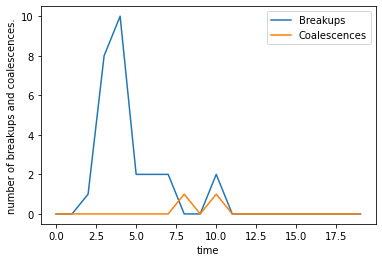

In [10]:
# time data
plt.clf()
time_data       = np.zeros(len(report_table))
breakups        = np.zeros(len(report_table))
coalescences    = np.zeros(len(report_table))

for i in range(len(report_table) ):
    time_data[i]    = report_table[i][0]
    breakups[i]     = report_table[i][1]
    coalescences[i] = report_table[i][2]

plt.plot(time_data, breakups, label='Breakups')
plt.plot(time_data, coalescences, label='Coalescences')
plt.xlabel("time")
plt.ylabel("number of breakups and coalescences.")
plt.legend(loc='upper right')
plt.savefig("coalescences_and_breakup_distributopms.png")
# develop the axes names and titles
time.sleep(2)

## Deformation visualitzaion
The deformation
$$dL =  2 r_0 \dot{ \varepsilon} \exp \left[ \dot{ \varepsilon} ( t - t_{init} ) \right] \cdot \delta t $$

It results in the deformation index variation over time:
$$DI = \frac{L-B}{L+B}\Rightarrow FI = \frac{2B}{B+L} $$
That we plot.

## $L$ and $B$

L and B data saved to L_B_report_end.csv


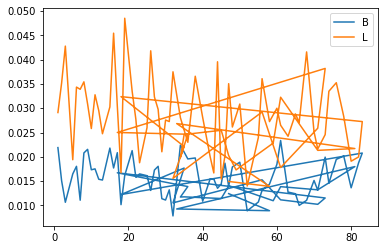

In [11]:
plt.clf()
x=[]; B=[]; L= []
for i in list_of_particles:
    x.append(i.ID)
    B.append(i.B)
    L.append(i.L)

plt.plot(x, B, label='B')
plt.plot(x, L, label='L')
plt.legend()
plt.savefig("L and B at the end.png", dpi=300)

# Save lists in a columnar CSV file
output_file = "L_B_report_end.csv"
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header row
    writer.writerow(["x", "L", "B"])
    # Write rows of data
    for row in zip(x, L, B):
        writer.writerow(row)

print(f"L and B data saved to {output_file}")

## Coalescence and breakup


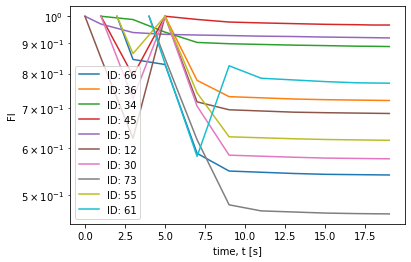

In [12]:
# checking the broken up particle's path
plt.clf()
time_axis = np.linspace(0, input_data.t_end, int(input_data.t_end/input_data.delta_t )  )

# pick 10 particles
samples = np.random.choice(list_of_particles, size=10)


for particle in samples:
    plt.plot( particle.fibrillation_index.keys(), particle.fibrillation_index.values(), label='ID: ' + str(particle.ID) )

plt.legend()
plt.xlabel('time, t [s]')
plt.ylabel('FI')
plt.yscale("log")
plt.savefig("FI along X.png", dpi=300)

## $X-t$

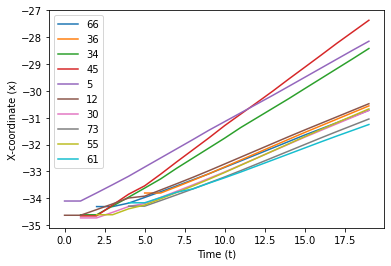

In [13]:
plt.clf()
for i in samples:
    # Extract time and x-coordinates
    times = list(i.location.keys())
    x_coords = [pos[0] for pos in i.location.values()]  # Extract the x-component
    
    # Plot x vs t
    plt.plot(times, x_coords, label=i.ID)


# Add labels and legend
plt.xlabel("Time (t)")
plt.ylabel("X-coordinate (x)")
plt.legend()
plt.savefig("X over time.png", dpi=300)
plt.show()


## $X-R$

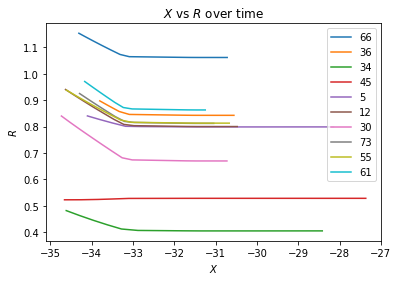

In [14]:
plt.clf()
for i in samples:
    # Extract time and coordinates
    times = list(i.location.keys())
    x_coords = [pos[0] for pos in i.location.values()]  # Extract x-component
    yz_magnitude = [np.sqrt(pos[1]**2 + pos[2]**2) for pos in i.location.values()]  # Compute sqrt(y^2 + z^2)
    
    # Plot x vs sqrt(y^2 + z^2) over time
    plt.plot(x_coords, yz_magnitude, label=f"{i.ID}")
    #plt.scatter(times, x_coords, label=f"{i.ID} (x vs t)", s=5)  # Optional: Add scatter for x over time

# Add labels and legend

plt.xlabel(r"$X$")
plt.ylabel(r"$R$")
plt.title(r"$X$ vs $R$ over time")
plt.legend()
plt.savefig("X and R over time.png", dpi=300)
#plt.show()

### Plotting radial samples

Saving figures of radial distributions at  x:  -30
All files processed.


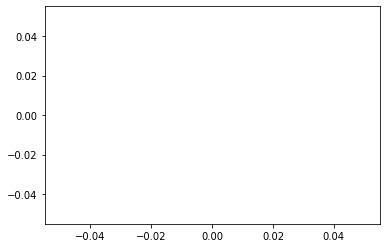

<Figure size 432x288 with 0 Axes>

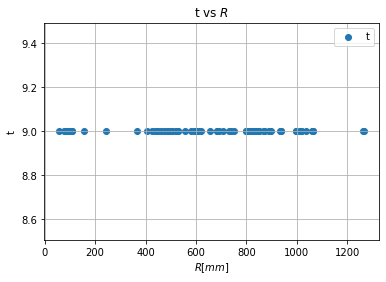

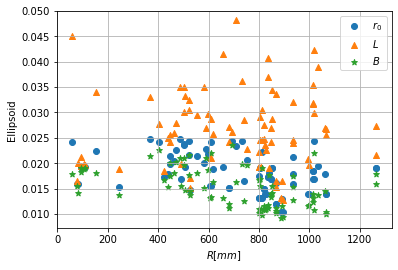

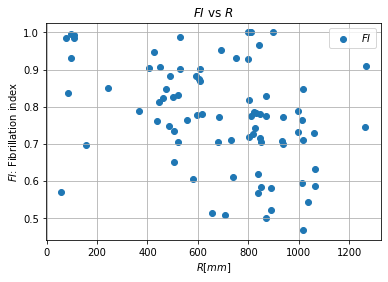

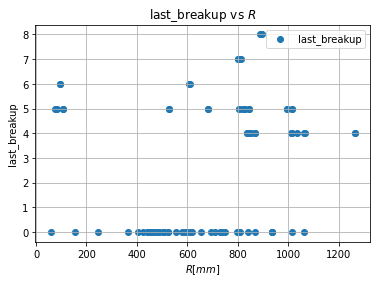

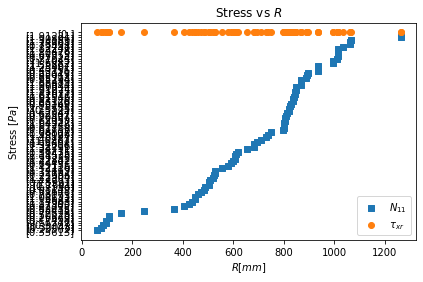

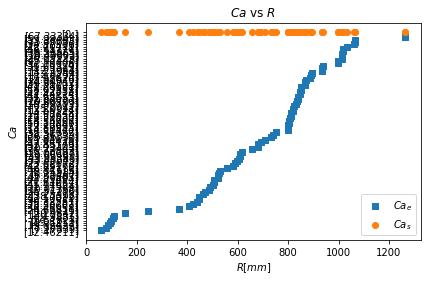

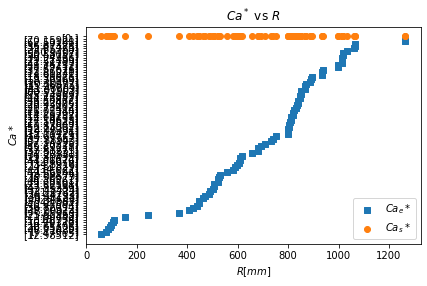

In [15]:
plt.clf()
# Directory containing the CSV files

csv_directory = "."  # Replace with the appropriate directory if not the current one

# Find all CSV files ending with '_properties.csv'
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('_properties.csv')]

if not csv_files:
    print("No CSV files ending with '_properties.csv' found.")
else:
    for csv_file in csv_files:
        plt.plot(); plot = True
        #extract location:
        location = csv_file[ csv_file.find('_') +1 :  csv_file.find('_',  csv_file.find('_') +1 ) ]
        print('Saving figures of radial distributions at ', input_data.stretching_axis + ': ', location)

        # Read the CSV file into a DataFrame
        file_path = os.path.join(csv_directory, csv_file)
        df = pd.read_csv(file_path)

        # Ensure the required columns are present
        required_columns = {'Y', 'Z'}
        if not required_columns.issubset(df.columns):
            print(f"Skipping {csv_file}: Missing required columns {required_columns}.")
            continue

        # Calculate the new column R
        df['R'] = np.sqrt(df['Y']**2 + df['Z']**2)

        # Sort the DataFrame by R
        df = df.sort_values(by='R').reset_index(drop=True)

        # Drop excluded columns from the columns to plot
        excluded_columns = {'X', 'Y', 'Z', 'breakup', 'coalesce', 'R'}
        columns_to_plot = [col for col in df.columns if col not in excluded_columns]

        if not columns_to_plot:
            print(f"Skipping {csv_file}: No columns available for plotting against R.")
            continue
        
        # Plot each column versus R
        plt.figure()
        for column in columns_to_plot:         

            if 'r_0' in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$r_0$')
                plot = False
            elif 'L' == column:
                plt.scatter(df['R']*1000, df[column], label=r'$L$', marker='^')
                plot = False
            elif 'B' == column:
                plt.scatter(df['R']*1000, df[column], label=r'$B$', marker='*')
                plt.ylabel("Ellipsoid")
                plot = True
            elif "fibrillation" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$FI$')
                plt.ylabel(r'$FI$: Fibrillation index')
                plt.title(r'$FI$ vs $R$')
                plot = True

            elif "N_11" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$N_{11}$', marker='s')
                plt.ylabel(r'Stress $[Pa]$')
                plt.title(r'Stress vs $R$')
                plot = False
            elif "shear" in column:
                plt.scatter(df['R']*1000, df[column], label=r'$\tau_{xr}$')
                plot = True

            elif "Ca_e" == column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_e$', marker='s')
                plt.ylabel(r'$Ca$')
                plt.title(r'$Ca$ vs $R$')
                plot = False
            elif "Ca_s" == column:
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_s$')
                plot = True

            elif "Ca_star_e" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_e*$', marker='s')
                plt.title(r'$Ca^*$ vs $R$')
                plt.ylabel(r'$Ca*$')
                plot = False
            elif "Ca_star_s" in column:
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_s*$')
                plot = True

            else: 
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=column)
                plt.ylabel(column)
                plt.title(column + r' vs $R$')
                plot = True

            plt.xlabel(r'$R[mm]$')
            plt.legend()
            plt.grid()
            if plot: plt.savefig(input_data.filename[:-5] +'_'+ location + '_' + column+'.png', dpi=300)
            plot = True


print("All files processed.")




## Plot all the radial info

All files processed.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

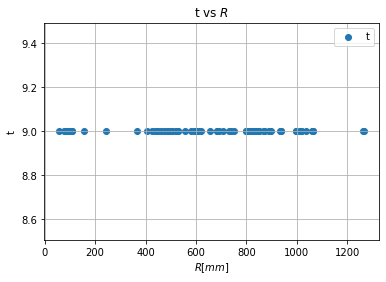

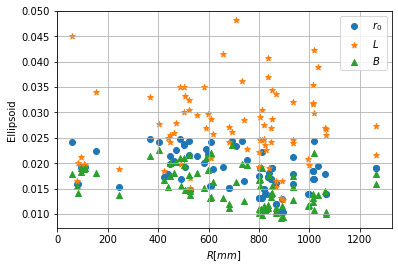

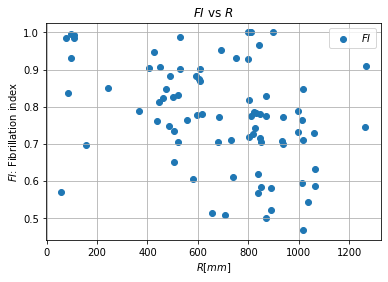

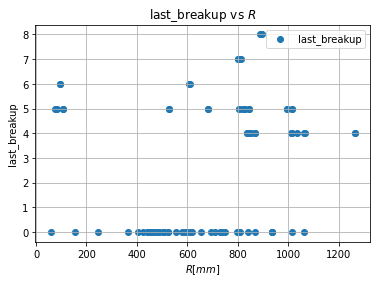

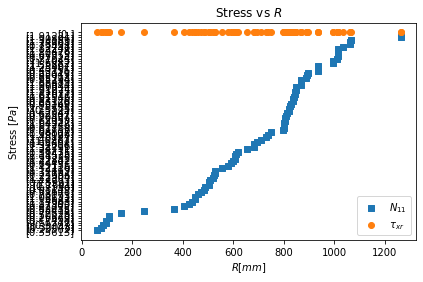

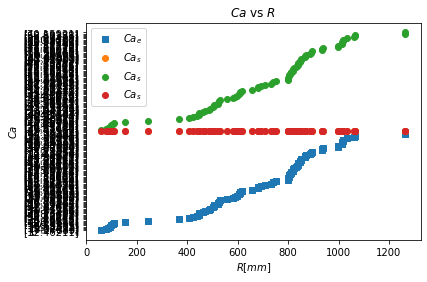

In [16]:
plt.clf()
# Directory containing the CSV files
csv_directory = "."  # Replace with the appropriate directory if not the current one

# Find all CSV files ending with '_properties.csv'
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('_properties.csv')]

if not csv_files:
    print("No CSV files ending with '_properties.csv' found.")
else:
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        file_path = os.path.join(csv_directory, csv_file)
        df = pd.read_csv(file_path)

        # Ensure the required columns are present
        required_columns = {'Y', 'Z'}
        if not required_columns.issubset(df.columns):
            print(f"Skipping {csv_file}: Missing required columns {required_columns}.")
            continue

        # Calculate the new column R
        df['R'] = np.sqrt(df['Y']**2 + df['Z']**2)

        # Sort the DataFrame by R
        df = df.sort_values(by='R').reset_index(drop=True)

        # Drop excluded columns from the columns to plot
        excluded_columns = {'X', 'Y', 'Z', 'breakup', 'coalesce', 'R'}
        columns_to_plot = [col for col in df.columns if col not in excluded_columns]

        if not columns_to_plot:
            print(f"Skipping {csv_file}: No columns available for plotting against R.")
            continue
        
        # Plot each column versus R
        plt.figure()
        for column in columns_to_plot:         

            if 'r_0' in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$r_0$')
            elif 'B' == column:
                plt.scatter(df['R']*1000, df[column], label=r'$B$', marker='^')
            elif 'L' == column:
                plt.scatter(df['R']*1000, df[column], label=r'$L$', marker='*')
                plt.ylabel("Ellipsoid")
            elif "fibrillation" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$FI$')
                plt.ylabel(r'$FI$: Fibrillation index')
                plt.title(r'$FI$ vs $R$')

            elif "N_11" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$N_{11}$', marker='s')
                plt.ylabel(r'Stress $[Pa]$')
                plt.title(r'Stress vs $R$')
            elif "shear" in column:
                plt.scatter(df['R']*1000, df[column], label=r'$\tau_{xr}$')

            elif "Ca_e" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_e$', marker='s')
                plt.ylabel(r'$Ca$')
                plt.title(r'$Ca$ vs $R$')
            elif "Ca_s" in column:
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_s$')

            elif "Ca_star_e" in column:
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_e^*$', marker='s')
                plt.title(r'$Ca^*$ vs $R$')
            elif "Ca_star_s" in column:
                plt.scatter(df['R']*1000, df[column], label=r'$Ca_s^*$')

            else: 
                plt.figure()
                plt.scatter(df['R']*1000, df[column], label=column)
                plt.ylabel(column)
                plt.title(column + r' vs $R$')

            plt.xlabel(r'$R[mm]$')
            plt.legend()
            plt.grid()
            plt.savefig(csv_file[:-4]+'.png', dpi=300)


print("All files processed.")
